# lung cancer detection from microarray data
### Introduction 
Machine learning is used in many applications around the world, the healthcare industry is no exception. Lung cancer is one of the most leading causes of cancer deaths in the world and machine learning algorithms can play an important role in predicting the presence or absence of such a disease. This information can provide important insights to doctors who can then adapt their diagnosis and treatment to the patient. 
### Contribution 
In this project I will present a binary PSO feature selection using Random Forest Classifier for lung cancer detection. 
### Data loading and preparition
The dataset is available in http://math.bu.edu/people/sray/software/prediction/datasets/lung_annarbor_outcome.csv

In [872]:
import pandas as pd 
import numpy as np
data = pd.read_csv('lung_annarbor_outcome.csv')
df = pd.DataFrame.transpose(data)
#creation of labels
f  = [1]*24 #1 representes the presence of lung cancer
ff = [0]*62 #0 representes the absence of lung cancer
f.extend(ff)
y = np.asarray(f)# Ground truth labels

In [873]:
df.shape

(86, 7129)

#### Feature scaling 

In [874]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(df)

## Feature selection
Th size of the dataset is 86*7129; 86 observation and 7129 feature. This poses a problem for machine learning algorithms. To address this issue, we need to select the relevant features using an optimization algorithm called Particle Swarm Optimization(PSO).<br>
#### Particle Swarm Optimization
PSO is a metaheuristic and a population-based stochastic optimization algorithm, inspired by the social behavior of bird flocking or fish schooling. Over a number of iterations of PSO algorithm, a group of particles have their values adjusted closer to the member whose value is closest to the target at any given moment.<br>
I am going to use the Binary PSO algorithm to perform feature selection to improve classifier performance. For a Binary PSO, the position of the particles are expressed in two terms: 0 or 1. If we have a particle $X$ on m-dimensions, then it's position can be defined as:<br>

<center>$X = [x_1,x_2,...,x_m]$ where $x_i\in \{0,1\}.$</center>

To perform feature selection, we are going to assign each feature as a dimension of a particle. Hence, once we’ve implemented Binary PSO and obtained the best position, we can then interpret the binary array simply as turning a feature on and off. Now we have to define the objective function we want to optimize.
#### The objective function
The objective function we are going to use here is (<a href="https://www.sciencedirect.com/science/article/pii/S1568494613001361"> Vieira, Mendoca, Sousa, et al. (2013)</a>):<br> 
<center>$f(X) = \alpha (1-P)+(1-\alpha)(1-\frac{N_f}{N_t})$</center>
Where $\alpha$ is a hyperparameter that decides the tradeoff between the classifier performance $P$, and the size of the feature subset $N_f$ with respect to the total number of features $N_t$. The classifier performance can be the accuracy, F-score, precision, and so on.


#### Splitting the dataset into training and test set

In [875]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=86)

#### Writing the objective function
as previously mentioned, we can write our objective function by simply taking the performance of the classifier and the size of the feature subset divided by the total, to return an error in the data. In our case, cancer detection, Recall is a better measure for classification performance. 

In [876]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import recall_score
classifier = RandomForestClassifier(n_estimators=6, random_state=86)
def f_per_particle(m, alpha):
    total_features = 7129
    # Get the subset of the features from the binary mask
    if np.count_nonzero(m) == 0:
        X_subset = X_train
        Xtest_subset = X_test
    else:
        X_subset = X_train[:,m==1]
        Xtest_subset = X_test[:,m==1]
    # Perform classification and store performance in P
    classifier.fit(X_subset, y_train)
    P = recall_score(y_test, classifier.predict(Xtest_subset), average="macro")
    # Compute for the objective function
    j = (alpha * (1.0 - P)
        + (1.0 - alpha) * (1 - (Xtest_subset.shape[1] / total_features)))

    return j

In [877]:
def f(x, alpha=0.8):
    
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

#### Optimize the objective function $f$

In [878]:
import pyswarms as ps
# Initialize swarm
options = {'c1': 0.5, 'c2': 0.5, 'w':0.9, 'k': 30, 'p':2}
dimensions = 7129 #number of features
optimizer = ps.discrete.BinaryPSO(n_particles=30, dimensions=dimensions, options=options)
# Perform optimization
cost, pos = optimizer.optimize(f, iters=10)

2019-05-09 13:49:25,504 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 30, 'p': 2}




pyswarms.discrete.binary:   0%|                                           |0/10



pyswarms.discrete.binary:   0%|                           |0/10, best_cost=0.32



pyswarms.discrete.binary:  10%|██▋                        |1/10, best_cost=0.32



pyswarms.discrete.binary:  10%|██▌                       |1/10, best_cost=0.239



pyswarms.discrete.binary:  20%|█████▏                    |2/10, best_cost=0.239



pyswarms.discrete.binary:  20%|█████▏                    |2/10, best_cost=0.239



pyswarms.discrete.binary:  30%|███████▊                  |3/10, best_cost=0.239



pyswarms.discrete.binary:  30%|███████▊                  |3/10, best_cost=0.239



pyswarms.discrete.binary:  40%|██████████▍               |4/10, best_cost=0.239



pyswarms.discrete.binary:  40%|██████████▍               |4/10, best_cost=0.239



pyswarms.discrete.binary:  50

#### The selected features:

In [879]:
X_train = X_train[:,pos==1]
X_test = X_test[:,pos==1]

## Feature extraction 
To perform feature extraction we will use Principal Component Analysis (PCA) algorithm. PCA is a dimensionality reduction algorithm used to convert a set of correlated variables into a set of values of linearly uncorrelated variables called principal components. 

In [913]:
from sklearn.decomposition import PCA
pca = PCA(n_components =11,random_state=86)
Xpc = pca.fit(X_train)
Xpca = Xpc.transform(X_train)
Xtestpca = Xpc.transform(X_test)

## Model fitting

In [914]:
cl = classifier.fit(Xpca, y_train)

## Model evaluation
#### Accuracy:

In [915]:
accuracy = (cl.predict(Xtestpca)==y_test).mean()
print(accuracy)

0.8333333333333334


#### Confusion matrix:

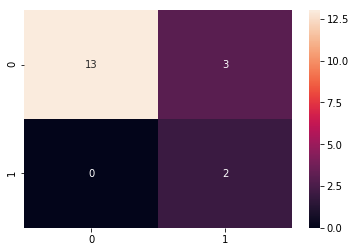

In [916]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
sb.heatmap(confusion_matrix(cl.predict(Xtestpca),y_test),annot=True)

#### Precision, recall and F1-score:

In [871]:
from sklearn.metrics import classification_report
print(classification_report(cl.predict(Xtestpca),y_test))

             precision    recall  f1-score   support

          0       1.00      0.81      0.90        16
          1       0.40      1.00      0.57         2

avg / total       0.93      0.83      0.86        18

